# Задача. Сделать классификатор по категориям рекламных роликов на основе их текстовых описаний.

Здесь представлен сокращённый вариант построения модели.  
Более подробный -- в отдельном проекте

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import optuna
from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization import plot_optimization_history
from umap import UMAP
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import pymorphy2

RAND = 10

## Загрузка датасетов

In [ ]:
df_plus_cats_cleaned_casino2 = pd.read_csv(
    'data\df_plus_cats_cleaned_casino2.csv', index_col=0, keep_default_na=False)
df_cats = pd.read_csv('data\df_cats.csv', index_col=0, keep_default_na=False)

Описания полей основного датасета  
  
Таблица содержит информацию о рекламных креативах.  

- category_id - категория, к которой относится рекламный креатив. Целевая переменная. (Например Food & Drinks или Hobbies)
- title - заголовок рекламаного креатива, обычно это название рекламируемого продукта.
- description - описание рекламного ролика, более подробная информация о ролике и продукте.  
- adomain - домен рекламодателя, зачастую содержит название продукта.
- bundle - наименование бандла, также может содержать название продукта.

In [ ]:
df_plus_cats_cleaned_casino2

,title,description,adomain,bundle,category_id,parent_id,iab_code,name,text,text_count
1,Приложения в Google Play Строки от МТС,"Книги, подкасты и аудиокниги",play.google.com,,149,0,IAB9,Hobbies & Interests,"Приложения в Google Play Строки от МТС Книги, ...",12
2,,,play.google.com,,149,0,IAB9,Hobbies & Interests,play.google.com,1
3,,,innogames.com,com.innogames.elvenar,149,0,IAB9,Hobbies & Interests,innogames.com com.innogames.elvenar,2
4,,,mamba.ru,ru.mamba.client,149,0,IAB9,Hobbies & Interests,mamba.ru ru.mamba.client,2
5,,,bigo.sg,sg.bigo.live,149,0,IAB9,Hobbies & Interests,bigo.sg sg.bigo.live,2
...,...,...,...,...,...,...,...,...,...,...
2483,Ksenukai - LVNr.7Maijs - Page 1,SIRSNGM SARUNM. NO PADOMA LDZ RISINJUMAM Piedv...,view.publitas.com,,331,0,IAB20,Travel,Ksenukai - LVNr.7Maijs - Page 1 SIRSNGM SARUNM...,19
2484,Ksenukai - LVZibenigiepiedavajumi121505 - Page 1,12.15.05.2022. 4 TIKAI DIENAS ZIBENGIE PIEDVJU...,view.publitas.com,,331,0,IAB20,Travel,Ksenukai - LVZibenigiepiedavajumi121505 - Page...,28
2485,Ksenukai - LVZibenigiepiedavajumi161906 - Page 1,LVZibenigiepiedavajumi161906,view.publitas.com,,331,0,IAB20,Travel,Ksenukai - LVZibenigiepiedavajumi161906 - Page...,8
2486,Ksenukai - LVNr.10JunijsJulijs - Page 1,IZ NO PADOMA LDZ RISINJUMAM P RDOAN Piedvjums ...,view.publitas.com,,331,0,IAB20,Travel,Ksenukai - LVNr.10JunijsJulijs - Page 1 IZ NO ...,32


Описания полей датасета категорий 
   
В таблице id категорий соответствуют их коду и словесному названию  

- id
- parent_id - для подкатегорий, id родительской категории.
- iab_code - код категории по спецификации OpenRTB.  
- name - наименование категории.

In [ ]:
df_cats

,id,parent_id,iab_code,name
0,1,0,IAB1,Arts & Entertainment
1,2,1,IAB1-1,Books & Literature
2,3,1,IAB1-2,Celebrity Fan/Gossip
3,4,1,IAB1-3,Fine Art
4,5,1,IAB1-4,Humor
...,...,...,...,...
387,388,0,IAB26,Illegal Content
388,389,288,IAB26-1,Illegal Content
389,390,288,IAB26-2,Warez
390,391,288,IAB26-3,Spyware/Malware


## Feature engineering.

Подзадача. С помощью библиотек NLP из текстовых признаков создать числовые признаки.

Анализ датасета

In [ ]:
df_plus_cats_cleaned_casino2['text'] = \
    df_plus_cats_cleaned_casino2['title'] + ' ' + \
    df_plus_cats_cleaned_casino2['description'] + ' ' + \
    df_plus_cats_cleaned_casino2['adomain'] + ' ' + \
    df_plus_cats_cleaned_casino2['bundle']

In [ ]:
df_plus_cats_cleaned_casino2['text_count'] = df_plus_cats_cleaned_casino2['text'].apply(
    lambda x: len(x.split()))

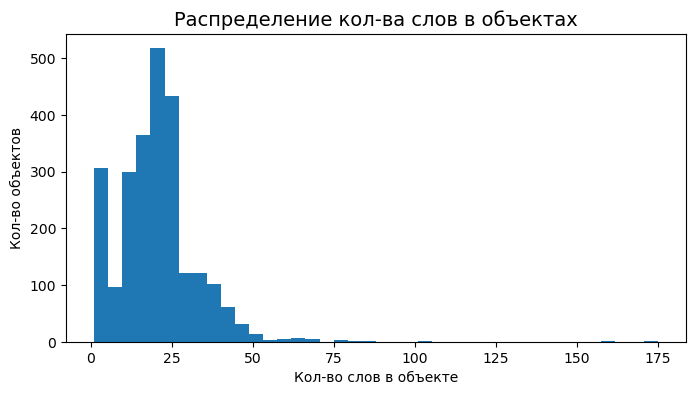

In [ ]:
plt.figure(figsize=(8, 4))

plt.title('Распределение кол-ва слов в объектах', fontsize=14)
plt.hist(x='text_count', data=df_plus_cats_cleaned_casino2, bins=40)

plt.xlabel('Кол-во слов в объекте')
plt.ylabel('Кол-во объектов')
plt.show()

In [ ]:
# Как в дальнейшем оказалось, результат получается лучше если не удалять объекты
# с большим количеством слов

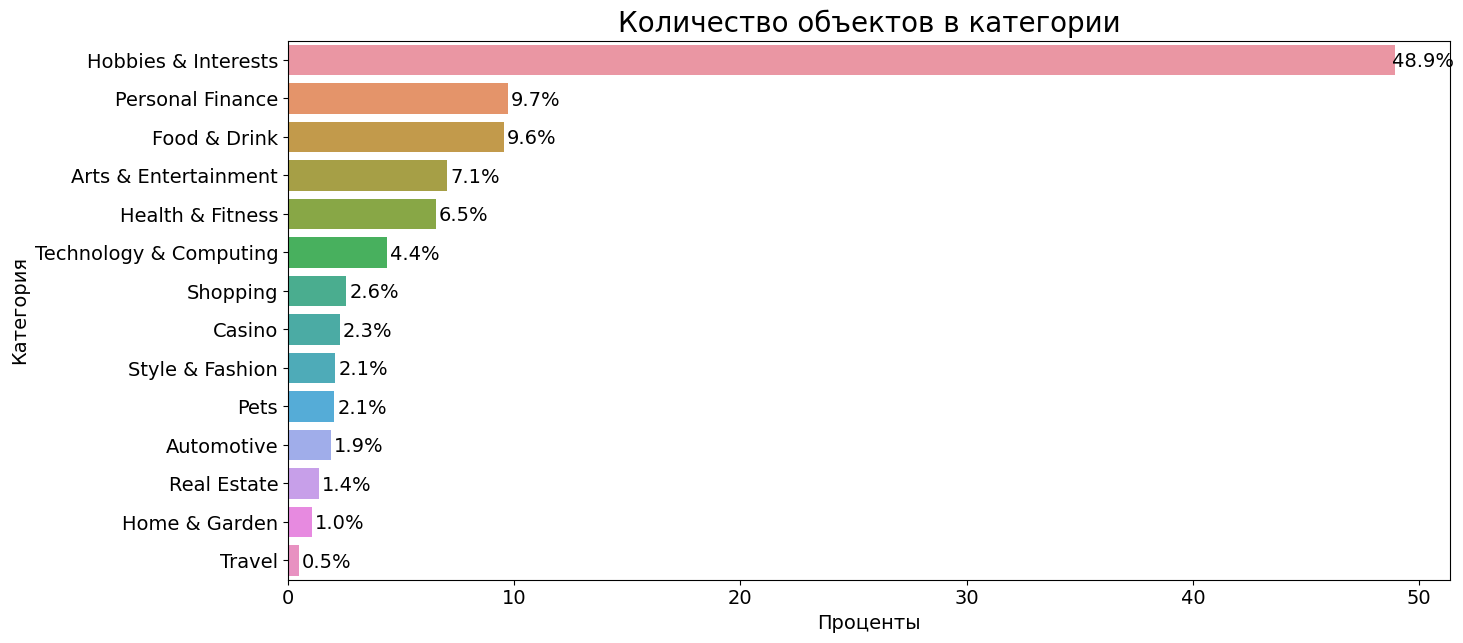

In [ ]:
def plot_text(ax):
    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_width())
        ax.annotate(
            percentage,  # текст
            # координата xy
            (p.get_width(), p.get_y() + p.get_height()),
            # центрирование
            ha='center',
            va='center',
            xytext=(20, 10),
            # точка смещения относительно координаты
            textcoords='offset points',
            fontsize=14)
        
# нормирование на размер датасета
norm_target = (df_plus_cats_cleaned_casino2
               .name
               .value_counts(normalize=True)
               .mul(100)
               .rename('percent')
               .reset_index())

plt.figure(figsize=(15, 7))
ax = sns.barplot(y='index', x='percent', data=norm_target, orient='h')

plot_text(ax)

plt.title('Количество объектов в категории', fontsize=20)
plt.xlabel('Проценты', fontsize=14)
plt.ylabel('Категория', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

In [ ]:
# Пробовал брать сэмпл с сокращённым количеством объектов в категории
# Hobbies & Interests,
# но это привело к большому переобучению

Создание числовых признаков

In [ ]:
# Применим стемминг -- приведём слова к одному корню, чтобы сократить количество признаков
# и упростить модель.
morph = pymorphy2.MorphAnalyzer()

In [ ]:

df_text = list(df_plus_cats_cleaned_casino2['text'].values)
for i in range(len(df_text)):
    df_text[i] = " ".join(
        [morph.parse(word)[0].normal_form for word in df_text[i].split()])
    df_text[i] = re.sub(r"[^a-zA-Zа-яА-ЯЁё\s]", "", df_text[i])
    for word in ['google', 'ru', 'app', 'apps', 'com', 'android', 'apple', 'lv']:
        df_text[i] = re.sub(rf"\b{word}\b", "",
                            df_text[i], flags=re.IGNORECASE)

In [ ]:
vectorizer = TfidfVectorizer(max_df=0.9,
                            # Оставим только значимые слова,
                            # чтобы сократить количество признаков
                             max_features=9000,
                            #  strip_accents='unicode',
                            #  preprocessor='callable',
                            #  analyzer='char_wb',
                             ngram_range=(1, 1))
df_numbers = vectorizer.fit_transform(df_text).toarray()
df_numbers[:4]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# Наилучшие метрики качества получились именно при таких гиперпараметрах
# Большее уменьшение количества признаков снижает результаты метрик

In [ ]:
df_words = vectorizer.get_feature_names_out()
df_words[:4]

array(['abc', 'abenteuern', 'ability', 'ablians'], dtype=object)

In [ ]:
numbers_words = pd.DataFrame(df_numbers, columns=df_words)
numbers_words.head()

,abc,abenteuern,ability,ablians,about,abroad,absolviert,absorbing,accepted,access,...,яндексбраузер,яндексмузыка,янина,японский,яркий,ярко,ярмарка,ярославле,ярославль,яф
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# топ средних
numbers_words.mean().sort_values(ascending=False)

play                           0.038705
on                             0.038217
playgooglecom                  0.036945
and                            0.025398
the                            0.020723
                                 ...   
альбумин                       0.000030
кислотавитамин                 0.000030
кислотажелезомедьсодержание    0.000030
гр                             0.000030
накопить                       0.000030
Length: 8807, dtype: float64

In [ ]:
numbers_words.to_csv('data\\numbers_words.csv')

## Обучение ML model

Функция проверки на переобучение

In [2]:
def check_overfitting(model, X_train, y_train, X_test, y_test):
    """
    Проверка на overfitting
    """
    y_prob_train = model.predict_proba(X_train)
    y_prob_test = model.predict_proba(X_test)

    # Accuracy не применяем, т. к. при дисбалансе классов Accuracy всегда
    # высокая из-за того что легко попасть в имбалансный класс

    print(f'\nROC-AUC train: %.3f' %
          roc_auc_score(y_true=y_train,
                        y_score=y_prob_train,
                        multi_class='ovr'))
    print(f'ROC-AUC test: %.3f' %
          roc_auc_score(y_true=y_test,
                        y_score=y_prob_test,
                        multi_class='ovr'))

Подготовка данных

In [3]:
df_plus_cats_cleaned_casino2.drop(
    ['parent_id', 'iab_code', 'text'], axis=1, inplace=True)

In [4]:
X = numbers_words
y = df_plus_cats_cleaned_casino2['name'].values

In [5]:
# указываем stratify, чтобы захватить и в test и в train по объектам из каждого класса
# чтобы потом посчитать рок аук
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    shuffle=True,
                                                    random_state=RAND)
X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.16,
                                                    stratify=y_train,
                                                    shuffle=True,
                                                    random_state=RAND)

В более подробной версии, представленной в отдельном проекте, выяснили,  
что при сравнении бейзлайнов Catboost, Logreg и SVM,  
SVM показал наилучший результат.  
Что немудрено, т. к. 
SVM как раз особенно хорошо подходит для классификации сложных, но небольших наборов данных.  
А наш датасет состоит из ~2500 строк и большого количества признаков

### SVM baseline

In [12]:
svc = SVC(random_state=RAND,
          probability=True)
svc.fit(X_train_,
        y_train_)

SVC(probability=True, random_state=10)

In [10]:
# Проверка на переобучение
check_overfitting(svc, X_train_, y_train_, X_test, y_test)


ROC-AUC train: 1.000
ROC-AUC test: 0.983


### Tuning

Целевая функция


In [7]:
def objective_svc(trial,
                  X_train_: pd.DataFrame,
                  X_val: pd.DataFrame,
                  y_train_: pd.DataFrame,
                  y_val: pd.DataFrame,
                  random_state: int) -> float:
    params = {
        # Меньшее значение C ведет к более широкой полосе, но большему числу нарушений зазора
        # При переобучении сократить С
        "C": trial.suggest_categorical("C", [0.01, 1, 10, 100]),
        "kernel": trial.suggest_categorical(
            "kernel", ["linear", "poly", "rbf", "sigmoid"]),
        # Если модель переобучается, тогда надо уменьшить значение gamma, а 
        # если недообучается — то увеличить его
        "gamma": trial.suggest_categorical("gamma", ["scale", "auto"]),
        "probability": True,
        "break_ties": trial.suggest_categorical("break_ties", [True, False]),
        "random_state": random_state
    }

    if params["kernel"] == "poly":
       params["degree"] = trial.suggest_int("degree", 3, 5, 10)
    # coef0 управляет тем, насколько сильно полиномы высокой степени влияют 
    # на модель в сравнении с полиномами низкой степени
    if params["kernel"] in ["poly", "sigmoid"]:
       params["coef0"] = trial.suggest_float(
           "coef0", 0.0, 5.0)

    # SVC имеет встроенную 5-fold кросс-валидацию при
    # включённом параметре probability

    model = SVC(**params)
    model.fit(X_train_, y_train_)

    y_pred = model.predict_proba(X_val)
    roc_auc_predict = roc_auc_score(y_true=y_val,
                                    y_score=y_pred,
                                    multi_class='ovr')

    return roc_auc_predict


Работа Оптюны

In [8]:
study_svc = optuna.create_study(
    direction="maximize", study_name="SVC_Optuna")


def func(trial): return objective_svc(
    trial, X_train_, X_val, y_train_, y_val, random_state=RAND)


study_svc.optimize(func, n_trials=10, show_progress_bar=True)

[I 2023-05-12 22:17:43,205] A new study created in memory with name: SVC_Optuna
c:\Users\ABC\anaconda3\envs\creatives_classification\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-05-12 22:20:59,355] Trial 0 finished with value: 0.9703563272873449 and parameters: {'C': 100, 'kernel': 'sigmoid', 'gamma': 'scale', 'break_ties': True, 'coef0': 3.0525292064659872}. Best is trial 0 with value: 0.9703563272873449.


c:\Users\ABC\anaconda3\envs\creatives_classification\lib\site-packages\optuna\distributions.py:716: UserWarning: The distribution is specified by [3, 5] and step=10, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(


[I 2023-05-12 22:26:20,019] Trial 1 finished with value: 0.9731336382515743 and parameters: {'C': 100, 'kernel': 'poly', 'gamma': 'scale', 'break_ties': False, 'degree': 3, 'coef0': 1.8294640701763005}. Best is trial 1 with value: 0.9731336382515743.
[I 2023-05-12 22:28:31,389] Trial 2 finished with value: 0.9348148828386253 and parameters: {'C': 1, 'kernel': 'rbf', 'gamma': 'auto', 'break_ties': True}. Best is trial 1 with value: 0.9731336382515743.


c:\Users\ABC\anaconda3\envs\creatives_classification\lib\site-packages\optuna\distributions.py:716: UserWarning: The distribution is specified by [3, 5] and step=10, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(


[I 2023-05-12 22:31:41,328] Trial 3 finished with value: 0.9515605273314194 and parameters: {'C': 10, 'kernel': 'poly', 'gamma': 'auto', 'break_ties': False, 'degree': 3, 'coef0': 2.174538323386762}. Best is trial 1 with value: 0.9731336382515743.
[I 2023-05-12 22:35:29,250] Trial 4 finished with value: 0.9727616050168232 and parameters: {'C': 10, 'kernel': 'linear', 'gamma': 'auto', 'break_ties': False}. Best is trial 1 with value: 0.9731336382515743.
[I 2023-05-12 22:39:09,944] Trial 5 finished with value: 0.9513447684815183 and parameters: {'C': 0.01, 'kernel': 'linear', 'gamma': 'auto', 'break_ties': False}. Best is trial 1 with value: 0.9731336382515743.
[I 2023-05-12 22:41:31,850] Trial 6 finished with value: 0.9561833602601969 and parameters: {'C': 100, 'kernel': 'sigmoid', 'gamma': 'scale', 'break_ties': False, 'coef0': 4.28690579034802}. Best is trial 1 with value: 0.9731336382515743.
[I 2023-05-12 22:44:50,451] Trial 7 finished with value: 0.9740889371833445 and parameters: {

c:\Users\ABC\anaconda3\envs\creatives_classification\lib\site-packages\optuna\distributions.py:716: UserWarning: The distribution is specified by [3, 5] and step=10, but the range is not divisible by `step`. It will be replaced by [3, 3].
  warnings.warn(


[I 2023-05-12 22:49:59,197] Trial 9 finished with value: 0.9363089112763846 and parameters: {'C': 0.01, 'kernel': 'poly', 'gamma': 'auto', 'break_ties': False, 'degree': 3, 'coef0': 2.952106676090238}. Best is trial 7 with value: 0.9740889371833445.


In [33]:
print(f"\tBest value (auc): {study_svc.best_value:.5f}")
print(f"\tBest params:")

for key, value in study_svc.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (auc): 0.97409
	Best params:
		C: 1
		kernel: linear
		gamma: scale
		break_ties: False


In [9]:
plotly_config = {"staticPlot": True}

fig = plot_optimization_history(study_svc)
fig.show(config=plotly_config)

C:\Users\ABC\AppData\Local\Temp\ipykernel_20860\2794792167.py:1: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



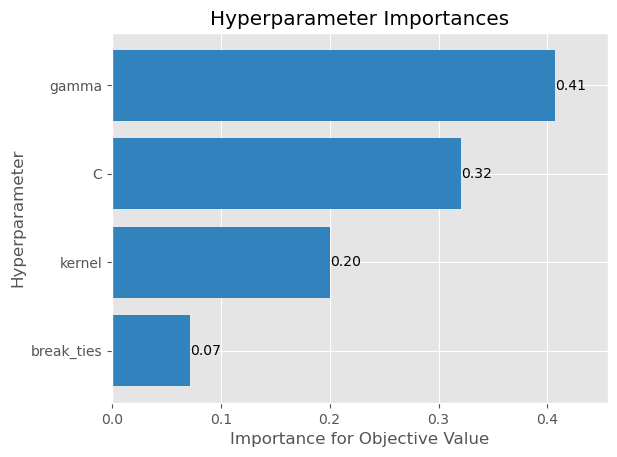

In [10]:
plot_param_importances(study_svc);

Обучение на лучшиих параметрах

In [11]:
svc_optuna = SVC(**study_svc.best_params,
                 random_state=RAND,
                 probability=True)
svc_optuna.fit(X_train_,
               y_train_)

SVC(C=1, kernel='linear', probability=True, random_state=10)

In [12]:
check_overfitting(svc_optuna, X_train_, y_train_, X_test, y_test)


ROC-AUC train: 1.000
ROC-AUC test: 0.984


Значение на тестовой выборке получилось выше, чем до тюнинга

Далее я также отдельно попробовал:
- Применял масштабирование при помощи StandardScaler
- Обучал на других ядрах при прочих дефолтных параметрах  
- Увеличивал С и гамма  
- Пробовал полиномы с большими степенями и средними значениями гамма и С

Но результат первой подборки оказался всё равно лучше

## Predict

In [13]:
numbers_words['predict'] = svc_optuna.predict(numbers_words.values)

c:\Users\ABC\anaconda3\envs\creatives_classification\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but SVC was fitted with feature names



In [14]:
numbers_words

,abc,abenteuern,ability,ablians,about,abroad,absolviert,absorbing,accepted,access,...,яндексмузыка,янина,японский,яркий,ярко,ярмарка,ярославле,ярославль,яф,predict
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Hobbies & Interests
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Hobbies & Interests
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Hobbies & Interests
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Hobbies & Interests
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Hobbies & Interests
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Travel
2477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Travel
2478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Travel
2479,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Travel


In [15]:
def get_df_predict_origin(df_predict, df_origin):
    '''Соединяет в один дф предсказанные категории и изначальные.'''
    
    df_origin = df_origin.reset_index(drop=True)
    # Соединяем только одну колонку predict со всем датасетом df_origin.
    df = pd.concat([df_predict['predict'],
                    df_origin],
                   axis=1)
    # Переименовываем столбцы.
    df.rename(columns={'predict': 'name_predict',
                       'category_id': 'cat_origin',
                       'name': 'name_origin'}, inplace=True)
    
    return df

In [16]:
df_predict_origin = get_df_predict_origin(numbers_words, df_plus_cats_cleaned_casino2)
df_predict_origin

,name_predict,title,description,adomain,bundle,cat_origin,name_origin,text_count
0,Hobbies & Interests,Приложения в Google Play Строки от МТС,"Книги, подкасты и аудиокниги",play.google.com,,149,Hobbies & Interests,12
1,Hobbies & Interests,,,play.google.com,,149,Hobbies & Interests,1
2,Hobbies & Interests,,,innogames.com,com.innogames.elvenar,149,Hobbies & Interests,2
3,Hobbies & Interests,,,mamba.ru,ru.mamba.client,149,Hobbies & Interests,2
4,Hobbies & Interests,,,bigo.sg,sg.bigo.live,149,Hobbies & Interests,2
...,...,...,...,...,...,...,...,...
2476,Travel,Ksenukai - LVNr.7Maijs - Page 1,SIRSNGM SARUNM. NO PADOMA LDZ RISINJUMAM Piedv...,view.publitas.com,,331,Travel,19
2477,Travel,Ksenukai - LVZibenigiepiedavajumi121505 - Page 1,12.15.05.2022. 4 TIKAI DIENAS ZIBENGIE PIEDVJU...,view.publitas.com,,331,Travel,28
2478,Travel,Ksenukai - LVZibenigiepiedavajumi161906 - Page 1,LVZibenigiepiedavajumi161906,view.publitas.com,,331,Travel,8
2479,Travel,Ksenukai - LVNr.10JunijsJulijs - Page 1,IZ NO PADOMA LDZ RISINJUMAM P RDOAN Piedvjums ...,view.publitas.com,,331,Travel,32


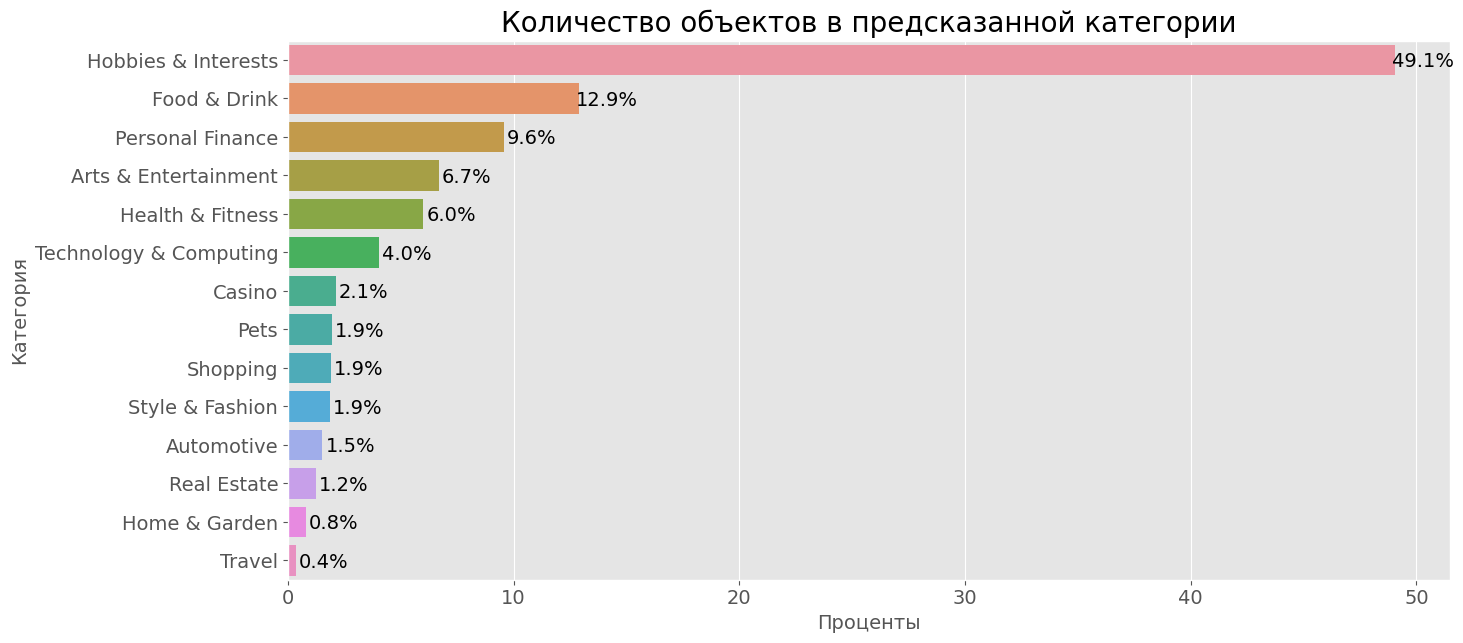

In [17]:
def plot_text(ax):
    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_width())
        ax.annotate(
            percentage,  # текст
            # координата xy
            (p.get_width(), p.get_y() + p.get_height()),
            # центрирование
            ha='center',
            va='center',
            xytext=(20, 10),
            # точка смещения относительно координаты
            textcoords='offset points',
            fontsize=14)
        
# нормирование на размер датасета
norm_target = (df_predict_origin
               .name_predict
               .value_counts(normalize=True)
               .mul(100)
               .rename('percent')
               .reset_index())

plt.figure(figsize=(15, 7))
ax = sns.barplot(y='index', x='percent', data=norm_target, orient='h')

plot_text(ax)

plt.title('Количество объектов в предсказанной категории', fontsize=20)
plt.xlabel('Проценты', fontsize=14)
plt.ylabel('Категория', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Видим, что распределение в целом похожее на то, которое делали для изначальных категорий

In [18]:
%time
um = UMAP(n_components=3, random_state=RAND,n_neighbors=15,min_dist=0.1)

Wall time: 0 ns


In [19]:
y_pred_train = svc_optuna.predict(X_train)
X_train_embedding = um.fit_transform(X_train)

<AxesSubplot:>

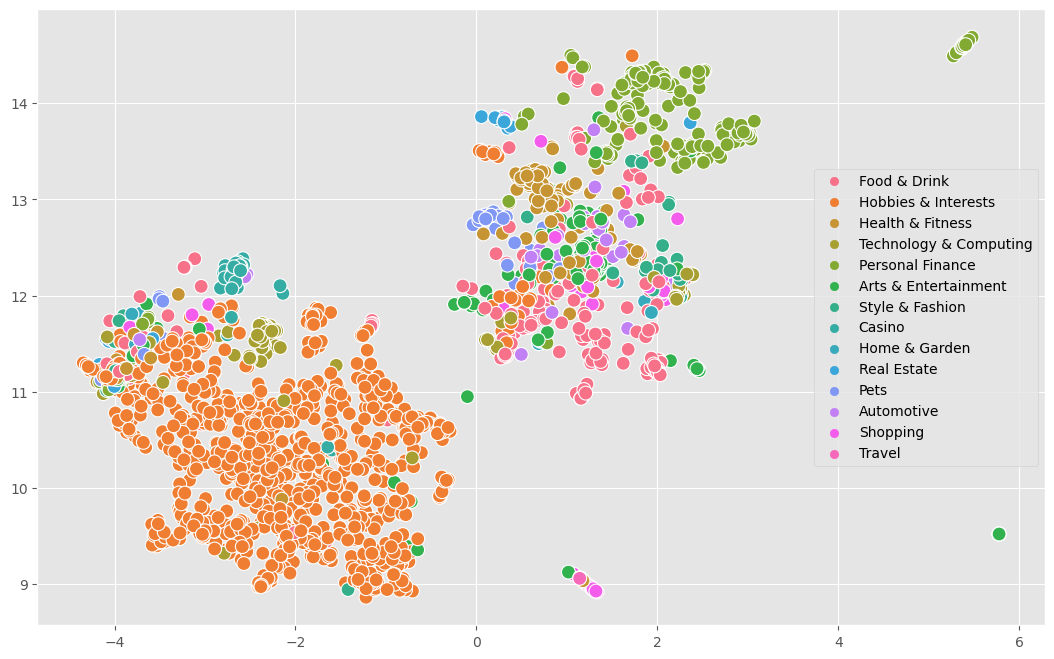

In [21]:
fig = plt.figure(figsize=(13, 8))
sns.scatterplot(x=X_train_embedding[:, 0],
                y=X_train_embedding[:, 1],
                hue=y_pred_train,
                s=100,
                legend='full')

Видны территории категорий со своими границами, с некоторыми выбросами.

In [22]:
X_test_embedding = um.fit_transform(X_test)

In [25]:
y_pred = svc_optuna.predict(X_test)

<AxesSubplot:>

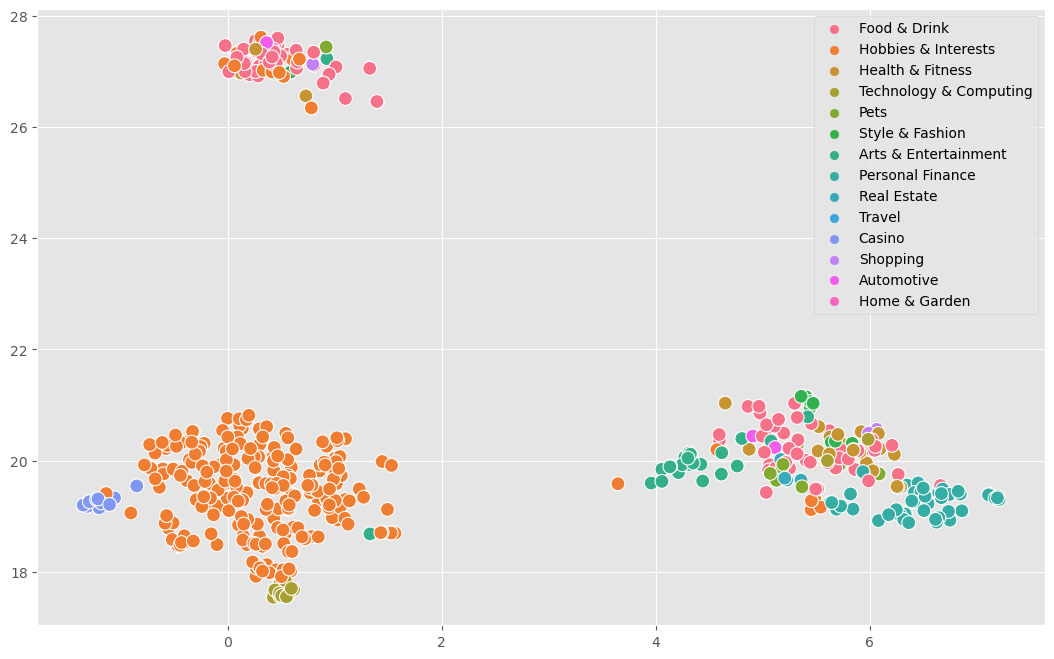

In [26]:
fig = plt.figure(figsize=(13, 8))
sns.scatterplot(x=X_test_embedding[:, 0],
                y=X_test_embedding[:, 1],
                hue=y_pred,
                s=100,
                legend='full')

На тесте разделение есть, но категории расположены в других местах.  
(Алгоритм не гарантирует что положение будет сохранено,  
т.к. задача нахожождения наилучшей проекции имеет много решений)  
Главное, что категории группируются, это хорошо

Посмотрим визуально датасет.

In [27]:
df_predict_origin[2000:2010]

,name_predict,title,description,adomain,bundle,cat_origin,name_origin,text_count
2000,Personal Finance,Дебетовая карта Tinkoff Black Дебетовая карта ...,Дебетовая карта с кэшбэком до 30. Получайте 6 ...,tinkoff.ru,,201,Personal Finance,28
2001,Personal Finance,Мгновенные денежные переводы в страны СНГ Быст...,"Выгодные, быстрые и удобные переводы денег за ...",tinkoff.ru,,201,Personal Finance,34
2002,Personal Finance,Кредитная карта с кешбэком МТС CASHBACK Мир оф...,Оформите кредитную кешбэк карту от МТС Банка и...,mtsbank.ru,,201,Personal Finance,47
2003,Personal Finance,Оформить заявку на кредитную карту онлайн,Оформить кредитную карту онлайн. Получить кред...,tinkoff.ru,,201,Personal Finance,20
2004,Personal Finance,Кредиты для бизнеса Кредиты на открытие и разв...,Кредит для малого бизнеса до 10 млн без залога...,tinkoff.ru,,201,Personal Finance,31
2005,Personal Finance,Акция от Халвы на покупку одежды - рассрочка о...,Обнови гардероб с Халвой 18 месяца рассрочки н...,halvacard.ru,,201,Personal Finance,25
2006,Personal Finance,Оборотный кредит Кредит на пополнение оборотны...,Оборотный кредит до 10 млн . Кредит на пополне...,tinkoff.ru,,201,Personal Finance,25
2007,Personal Finance,Черная пятница с Халвой оформить карту с расср...,Черная пятница вместе с картой рассрочки Халва...,halvacard.ru,,201,Personal Finance,44
2008,Personal Finance,Рефинансирование кредитов от наша ставка - реф...,Банк Хоум Кредит предлагает программу рефинанс...,homecredit.ru,homecredit.ru,201,Personal Finance,69
2009,Personal Finance,Нельзя войти на сайт Сбербанка в этом браузере.,,sberbank.ru,,201,Personal Finance,9


In [28]:
df_predict_origin[df_predict_origin['name_predict']
    != df_predict_origin['name_origin']].shape

(105, 8)

Количество отличающихся предсказанных и изначальных значений составляет примерно 4%

После визуального осмотра можно сказать, что среди различающихся значений модель где-то вернее предсказала категорию, где-то нет.
Но в общем и целом показала результат не хуже, чем изначальная разметка.